This is my analysis of the ASE libraries

In [1]:
#Code from the module
from ase import Atoms
from ase.optimize import BFGS
from ase.calculators.emt import EMT
from ase.visualize import view
from ase.io.trajectory import Trajectory
from ase.build import molecule
import os, sys
import numpy as np
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout


d = 0.9575
t = np.pi / 180 * 104.51
water = Atoms('H2O',
              positions=[(d, 0, 0),
                         (d * np.cos(t), d * np.sin(t), 0),
                         (0, 0, 0)],
              calculator=EMT())


dyn=BFGS(water,trajectory='H2O.traj')
dyn.run(fmax=.01)
traj = Trajectory('H2O.traj')



#Confirmation that the hydrogens are correct length (Theoretical=.96 Angstroms)
x1=np.array(water[0].position-water[2].position)#the vector from the hydrogens to the oxygen
x2=np.array(water[1].position-water[2].position)
h1=np.sqrt(x1.dot(x1))#magnitude of the vectors
h2=np.sqrt(x2.dot(x2))
print()
print('Distance from Oxygen to Hydrogen')
print('r1=',h1)
print('r2=',h2)
r=molecule('H2O').get_distance(0,2) #Pulled from database
print('theoretical r=',r)
print('percent error=',np.abs(((r-h1)/r)*100.))






      Step     Time          Energy         fmax
BFGS:    0 12:26:28        2.769632        8.6091
BFGS:    1 12:26:28        2.154560        4.4644
BFGS:    2 12:26:28        1.906812        1.3097
BFGS:    3 12:26:28        1.880255        0.2056
BFGS:    4 12:26:28        1.879488        0.0205
BFGS:    5 12:26:28        1.879479        0.0131
BFGS:    6 12:26:28        1.879464        0.0219
BFGS:    7 12:26:28        1.879422        0.0448
BFGS:    8 12:26:28        1.879339        0.0696
BFGS:    9 12:26:28        1.879201        0.0855
BFGS:   10 12:26:28        1.879039        0.0740
BFGS:   11 12:26:28        1.878912        0.0339
BFGS:   12 12:26:28        1.878885        0.0047

Distance from Oxygen to Hydrogen
r1= 1.098802399495793
r2= 1.0988023994957927
theoretical r= 0.9685650182625842
percent error= 13.446426288121478


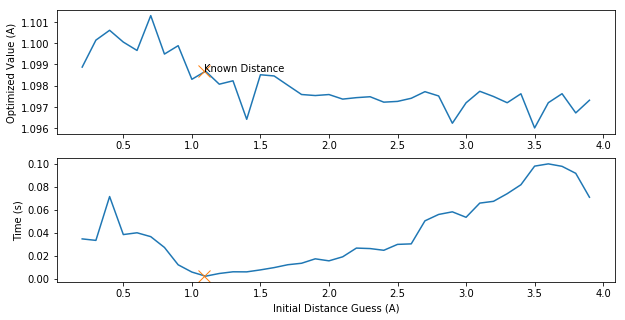

In [9]:
#Plot of optimized value vs initial distance
import matplotlib.pyplot as plt
import timeit

r=molecule('H2O').get_distance(0,2) #Pulled from database
d=np.arange(.2,4,.1)
for i in range(len(d)):
    d[i]=np.round(d[i],3)
value=[]
time=[]
for i in d:
    t = np.pi / 180 * 104.51
    water = Atoms('H2O',
                  positions=[(i, 0, 0),
                             (i * np.cos(t), i * np.sin(t), 0),
                             (0, 0, 0)],
                  calculator=EMT())
    with HiddenPrints():# Special function to hide the long output.
        time.append(timeit.Timer('BFGS(water).run(fmax=.05)',globals=globals()).timeit(number=1))#Timer
    x1=np.array(water[0].position-water[2].position)
    h1=np.sqrt(x1.dot(x1))
    value.append(h1)
    
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(d,value)
ax1.plot(1.09,value[list(d).index(1.1)],'x',markersize=12)
ax1.annotate('Known Distance',xy=(1.09,value[list(d).index([1.1])]))
ax1.set_ylabel('Optimized Value (A)')
ax2.plot(d,time)
ax2.plot(1.09,time[list(d).index(1.1)],'x',markersize=12)
ax2.set_xlabel('Initial Distance Guess (A)')
ax2.set_ylabel('Time (s)')
plt.show()


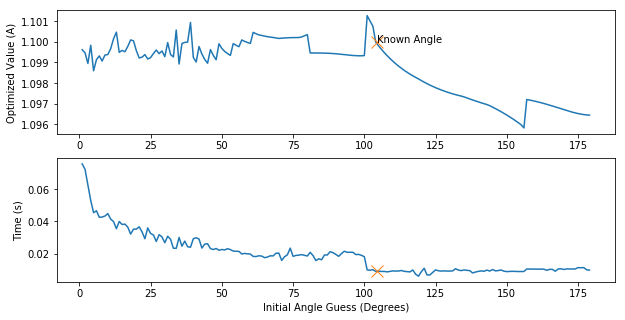

In [3]:
#Plot of optimized value vs angle between hydrogens
import matplotlib.pyplot as plt

r=molecule('H2O').get_distance(0,2) #Pulled from database
d=.9
angle=np.arange(1.,180.,1)
value=[]
time=[]
for i in angle:
    t = np.pi / 180 * i
    water = Atoms('H2O',
                  positions=[(d, 0, 0),
                             (d * np.cos(t), d * np.sin(t), 0),
                             (0, 0, 0)],
                  calculator=EMT())
    with HiddenPrints():# Special function to hide the long output.
        time.append(timeit.Timer('BFGS(water).run(fmax=.05)',globals=globals()).timeit(number=1))#Timer
    x1=np.array(water[0].position-water[2].position)
    h1=np.sqrt(x1.dot(x1))
    value.append(h1)

    
fig=plt.figure(figsize=(10,5))
ax1=fig.add_subplot(211)
ax2=fig.add_subplot(212)

ax1.plot(angle,value)
ax1.plot(104.51,value[list(angle).index(104.)],'x',markersize=12)
ax1.annotate('Known Angle',xy=(104.51,value[list(angle).index(104.)]))
ax1.set_ylabel('Optimized Value (A)')
ax2.plot(angle,time)
ax2.plot(104.51,time[list(angle).index(104.)],'x',markersize=12)
ax2.set_xlabel('Initial Angle Guess (Degrees)')
ax2.set_ylabel('Time (s)')
plt.show()


A standard Lennard-Jones potential to run for my optimization algorithms, minimum set at r=.4

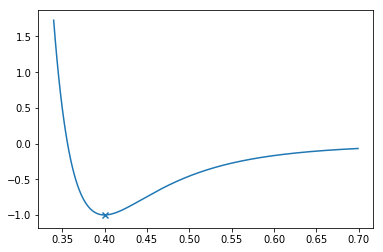

Theoretical min= 0.4


In [4]:
def potential(r,rmin=.4):
    return (((rmin/r)**12 -2*(rmin/r)**6))
rmin=.4
x=np.arange(.34,.7,.001)
y=potential(x,rmin)
plt.plot(x,y)
plt.scatter(x[y.argmin()],y.min(),marker='x')
plt.show()
print('Theoretical min=',rmin)

Implementation of a typical gradient descent with a variable step size. Kept to one dimensional, but can easily be generalized to multi-dimensinal with a modified derivative function. I added a sigma term to the step size calculation to dampen how fast it converges onto the minimum to allow for better accuracy.

In [5]:
#gradient descent
def derivative(f,x, dx=.001):
    return (f(x+dx)-f(x))/dx

def gradientDescent(f, x0, sigma,dx=0.01, N=10000):
    x1=x0
    x2=x1
    x_prev=None
    for i in range(N):
        if x_prev is None:
            dx = 0.01
        else:
            dfx = derivative(f, x1) - derivative(f, x_prev)
            dx = sigma*np.abs((x1 - x_prev)/dfx)
        x2=x1-derivative(f,x1)*dx
        if f(x2)<f(x1):
            x_prev=x1
            x1=x2
        else:
            cycle=i
            break
    return(x2,cycle)

gradientDescent(potential,10,.01)

(0.39999334266991915, 2349)

Implementation of a bisection method.

In [6]:
#Bisection Method
def bisection(f,x1,x2,N=1000,error=.0000001):
    new=(x1+x2)/2
    cycle=0
    while (np.abs(derivative(f,new))>error) and N>cycle:
        new=(x1+x2)/2
        cycle+=1
        if derivative(f,new)>0:
            x2=new
        else:
            x1=new
    return(new,cycle)
            
bisection(potential,.2,5)

(0.39950218740850685, 33)

Implementation of a conjugate gradient. While it can be modified to minimize non-linear functions, from what I understand there are better methods for those besides CG, so this example solves a system with a positive definite coefficient matrix.

In [7]:
##### As formulated by 'Numerical Optimization' Nocedal,Wright, pg.111 ######
def conjugateGradient(A,b,x0):
    rk=np.dot(A,x0)-b
    pk=-rk
    x=x0
    while not np.isclose(rk,np.zeros(rk.shape)).all():
        alphak=np.dot(rk,rk)/np.dot(np.dot(pk,A),pk)
        x=x+np.dot(alphak,pk)
        rk1=rk+np.dot(np.dot(alphak,A),pk)
        betak1=np.dot(rk1,rk1)/np.dot(rk,rk)
        pk1=-rk1+np.dot(betak1,pk)
        rk=rk1
        pk=pk1
    return x
                     
    

A = np.array([[3,-1],[-1,3]])
b = np.array([1,0])
x0 = np.array([2,2])
x=conjugateGradient(A,b,x0)
print('Solution to Ax=b')
print('A=',A)
print('b=',b)
print('Solution x=',x)
print("Verify:Ax-b=",np.dot(A,x)-b)




Solution to Ax=b
A= [[ 3 -1]
 [-1  3]]
b= [1 0]
Solution x= [0.375 0.125]
Verify:Ax-b= [-3.33066907e-16 -1.11022302e-16]


Implementation of BFGS.

In [8]:
from numpy import *
from math import *
from numpy.linalg import *


# Function 

testfn_vectorspace = lambda x: (1-x[0])**2 + 100*(x[1]-x[0]**2)**2

# Derivative

def testfn_d(x):
	return array([2*100*(x[1] - x[0]**2)*(-2*x[0]) - 2*(1.-x[0]), 2*100*(x[1]-x[0]**2)])

# Hessian
	
def hess(x):
	a = zeros((2,2))
	a[0,0] = 2 + 1200*x[0]**2 - 400*x[1]
	a[1,1] = 200
	a[0,1] = -400*x[0]
	a[1,0] = -400*x[0]
	return a


def Newton_BFGS(F,Fprime, Start, epsi = 10e-8, tol = 10e-6, sigma= 10**-1, beta = 10 ):
	
	def LineSearch(g,x,s,sigma= 10**-1, beta = 10, convergval = 0.00001):
		
		# QFind returns 1 or the proper value (based on the current slope) of the line
		# based on basic rise over run of the distance of the current function with
		# new vs old value
		
		def QFind(alpha):
			if abs(alpha) < convergval:
				return 1
			return (F(x + alpha*s) - F(x))/(alpha * dot(g,s))

		
		alpha = 1.

		# Double alpha until big enough
		while QFind(alpha) >= sigma:
			alpha=alpha * 2

		# BTacking
		while QFind(alpha)< sigma:
			alphap=alpha / ( 2.0* ( 1- QFind(alpha)))
			alpha=max(1.0/beta * alpha, alphap)
		return alpha

	# Startup
	x = Start
	xold = inf
	N = shape(x)[0]
	H = 1.0 * eye(N)
	counter = 1
	alpha = 1
	g = Fprime(x)
	while norm(g) > epsi and norm(xold - x) > tol:
		s = -dot(H,g)
		# Repeating the linesearch
		alpha = LineSearch(g,x,s)
		x = x+alpha*s
		gold = g
		g = Fprime(x)
		y = (g - gold)/alpha
		dotsy = dot(s,y)
		if dotsy>0:
			# Update H using estimation technique
			z = dot(H,y)
			H += outer(s,s)*(dot(s,y) + dot(y, z))/dotsy**2 - (outer(z,s)+ outer(s, z))/dotsy
		# Implement Counter 
		counter+=1

	return (x , counter)

(result, counter) =  Newton_BFGS(testfn_vectorspace, testfn_d, array([2,2]))

print ("Custom BFGS:")
print ("Final Result: " + str(result))
print ("Iteration Count: " + str(counter))

Custom BFGS:
Final Result: [1. 1.]
Iteration Count: 17
